<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Cleaning</a></span><ul class="toc-item"><li><span><a href="#Splitting-Gender-and-Filtering-Age" data-toc-modified-id="Splitting-Gender-and-Filtering-Age-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Splitting Gender and Filtering Age</a></span></li><li><span><a href="#Creating-Categorical-Shirt-Sizes" data-toc-modified-id="Creating-Categorical-Shirt-Sizes-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Creating Categorical Shirt Sizes</a></span></li><li><span><a href="#Rebuilding-the-Data-Frame" data-toc-modified-id="Rebuilding-the-Data-Frame-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Rebuilding the Data Frame</a></span></li><li><span><a href="#PCA" data-toc-modified-id="PCA-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>PCA</a></span></li></ul></li><li><span><a href="#Model-Selection" data-toc-modified-id="Model-Selection-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model Selection</a></span><ul class="toc-item"><li><span><a href="#Random-Forest-Regression" data-toc-modified-id="Random-Forest-Regression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Random Forest Regression</a></span></li><li><span><a href="#Random-Forest-Regression-With-Tuned-Hyperparameters" data-toc-modified-id="Random-Forest-Regression-With-Tuned-Hyperparameters-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Random Forest Regression With Tuned Hyperparameters</a></span></li></ul></li></ul></div>

In [1]:
import warnings
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import ensemble
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")

warnings.filterwarnings("ignore")

%matplotlib inline

# Data Cleaning

In [2]:
# Cleaning the features
df = pd.read_csv(
    'https://raw.githubusercontent.com/Padam-0/cluster_t-shirt_sizing/master/data.csv')

remove_cols = []

# I want to get rid of the columns with more than 2000 Nulls,
# because incomplete data won't be useful.
for i in df.columns:
    if 3900 - df.loc[:, i].astype(bool).sum() > 2000:
        remove_cols.append(i)

df2 = df.drop(remove_cols, axis='columns')

# I don't need these categorical variables
demographic_attributes = ['AGE IN YEARS', 'LOCATION',
                          'BIRTH DATE', 'MEASUREMENT DATE',
                          'MEASUREMENT SET TP',
                          'MEASURER NUMBER', 'COMPUTER NUMBER', 'RACE',
                          'GRADE LEVEL', 'HANDEDNESS', 'NUMBER OF BROTHERS',
                          'NUMBER OF SISTERS', 'TWIN', 'BIRTH ORDER',
                          'MOTHERS OCCUPATION', 'FATHERS OCCUPATION',
                          'MOTHERS EDUCATION', 'FATHERS EDUCATION',
                          'YEARS IN COMMUNITY', 'ANTHROPOMETER NO',
                          'CALIPER NO', 'GIRTH NO', 'PERSON #']

df2 = df2.drop(demographic_attributes, axis='columns')

# Recode Gender Variable


def binary_gender(gender):
    if gender == 1:
        return 0
    else:
        return 1


df2 = df2.replace(0, np.nan)
df2 = df2.dropna()

df2['gender_recode'] = df2['SEX'].apply(binary_gender)

df2 = df2.drop(['SEX'], axis='columns')

df2.head()
# Weight is in hectograms, everything else is millimeter.

,WEIGHT,STATURE,ERECT SITTING HEIGHT,MAXIMUM HIP BREADTH (SEATED),BUTTOCK-KNEE LENGTH,KNEE HEIGHT,HEAD CIRCUMFERENCE,HEAD BREADTH,SHOULDER BREADTH,SHOULDER-ELBOW LENGTH,...,HAND BREADTH,CHEST CIRCUMFERENCE,WAIST CIRCUMFERENCE,HIP CIRCUMFERENCE,UPPER THIGH CIRCUMFERENCE,CALF CIRCUMFERENCE,FOOT LENGTH,FOOT BREADTH,AGE IN MONTHS,gender_recode
12,499.0,1578.0,838.0,330.0,518.0,488.0,532.0,154.0,396.0,338.0,...,78.0,775.0,664.0,858.0,496.0,341.0,250.0,102.0,164.0,1
13,558.0,1618.0,826.0,325.0,568.0,511.0,549.0,152.0,402.0,359.0,...,80.0,859.0,723.0,856.0,526.0,331.0,243.0,98.0,167.0,1
15,400.0,1468.0,766.0,297.0,509.0,452.0,512.0,145.0,353.0,311.0,...,75.0,711.0,652.0,788.0,453.0,303.0,232.0,96.0,160.0,1
18,359.0,1528.0,778.0,279.0,518.0,503.0,547.0,145.0,355.0,323.0,...,73.0,712.0,612.0,730.0,440.0,276.0,234.0,82.0,148.0,1
19,378.0,1485.0,766.0,294.0,525.0,461.0,540.0,150.0,361.0,331.0,...,75.0,692.0,626.0,779.0,441.0,289.0,227.0,89.0,166.0,1


In [3]:
# Dataframe has data from newborns through 20 year olds
df2['AGE IN MONTHS'].describe()

count    3452.000000
mean      125.943801
std        52.816849
min        24.000000
25%        81.000000
50%       129.000000
75%       169.250000
max       240.000000
Name: AGE IN MONTHS, dtype: float64

## Splitting Gender and Filtering Age

In [4]:
df_men = df2[(df2.gender_recode == 0) &
             (df2['CHEST CIRCUMFERENCE'] >= 640)]
df_men.describe()

,WEIGHT,STATURE,ERECT SITTING HEIGHT,MAXIMUM HIP BREADTH (SEATED),BUTTOCK-KNEE LENGTH,KNEE HEIGHT,HEAD CIRCUMFERENCE,HEAD BREADTH,SHOULDER BREADTH,SHOULDER-ELBOW LENGTH,...,HAND BREADTH,CHEST CIRCUMFERENCE,WAIST CIRCUMFERENCE,HIP CIRCUMFERENCE,UPPER THIGH CIRCUMFERENCE,CALF CIRCUMFERENCE,FOOT LENGTH,FOOT BREADTH,AGE IN MONTHS,gender_recode
count,1076.000000,1076.000000,1076.000000,1076.000000,1076.000000,1076.000000,1076.000000,1076.000000,1076.000000,1076.000000,...,1076.000000,1076.000000,1076.000000,1076.000000,1076.000000,1076.000000,1076.000000,1076.000000,1076.000000,1076.0
mean,496.109665,1562.364312,808.869888,295.456320,523.544610,498.155204,547.620818,149.130112,382.682156,327.451673,...,79.342007,791.101301,685.407993,806.290892,478.637546,319.546468,243.710967,95.083643,158.790892,0.0
std,162.711647,164.062652,81.794034,38.552229,59.312675,53.923142,21.313153,6.151255,48.452607,37.360052,...,8.881449,106.726810,90.691247,102.947636,68.481216,40.208950,23.702440,9.758787,34.582398,0.0
min,201.000000,1116.000000,627.000000,208.000000,350.000000,350.000000,484.000000,132.000000,277.000000,223.000000,...,56.000000,640.000000,506.000000,573.000000,321.000000,232.000000,178.000000,71.000000,66.000000,0.0
25%,357.000000,1429.000000,742.000000,264.000000,476.000000,458.000000,532.000000,145.000000,344.000000,298.000000,...,72.000000,698.000000,616.000000,719.000000,425.000000,286.000000,226.000000,87.000000,134.000000,0.0
50%,461.000000,1546.000000,792.500000,293.000000,523.000000,499.000000,546.000000,149.000000,373.000000,326.000000,...,79.000000,771.000000,674.000000,800.000000,476.000000,317.000000,244.000000,95.000000,159.000000,0.0
75%,620.000000,1707.000000,881.000000,327.000000,573.000000,543.000000,563.000000,153.000000,422.250000,358.000000,...,87.000000,875.000000,742.250000,890.000000,524.250000,350.000000,262.000000,103.000000,185.000000,0.0
max,1123.000000,1944.000000,996.000000,430.000000,697.000000,628.000000,613.000000,171.000000,518.000000,484.000000,...,102.000000,1123.000000,1094.000000,1160.000000,753.000000,467.000000,311.000000,128.000000,240.000000,0.0


In [5]:
df_women = df2[(df2.gender_recode == 1) &
               (df2['CHEST CIRCUMFERENCE'] >= 640)]
df_women.describe()

,WEIGHT,STATURE,ERECT SITTING HEIGHT,MAXIMUM HIP BREADTH (SEATED),BUTTOCK-KNEE LENGTH,KNEE HEIGHT,HEAD CIRCUMFERENCE,HEAD BREADTH,SHOULDER BREADTH,SHOULDER-ELBOW LENGTH,...,HAND BREADTH,CHEST CIRCUMFERENCE,WAIST CIRCUMFERENCE,HIP CIRCUMFERENCE,UPPER THIGH CIRCUMFERENCE,CALF CIRCUMFERENCE,FOOT LENGTH,FOOT BREADTH,AGE IN MONTHS,gender_recode
count,1075.000000,1075.000000,1075.000000,1075.000000,1075.000000,1075.000000,1075.000000,1075.000000,1075.000000,1075.000000,...,1075.000000,1075.000000,1075.000000,1075.000000,1075.000000,1075.000000,1075.000000,1075.000000,1075.000000,1075.0
mean,461.106977,1530.157209,801.359070,311.118140,519.717209,475.854884,537.031628,146.087442,370.136744,317.937674,...,72.820465,765.927442,678.166512,834.053953,497.106047,312.818605,230.206512,88.312558,158.896744,1.0
std,113.873965,118.654493,63.076846,39.504119,46.885673,37.292110,16.962027,5.259184,34.300117,27.284466,...,5.291709,72.839294,75.683498,96.297978,61.642221,33.347580,15.190416,6.782397,33.683232,0.0
min,233.000000,1133.000000,631.000000,221.000000,388.000000,339.000000,493.000000,131.000000,263.000000,232.000000,...,58.000000,640.000000,511.000000,616.000000,364.000000,233.000000,184.000000,70.000000,68.000000,1.0
25%,369.000000,1445.000000,750.000000,279.000000,487.500000,452.000000,526.000000,142.000000,343.000000,299.000000,...,69.000000,708.000000,625.000000,756.500000,450.000000,287.000000,221.000000,84.000000,134.000000,1.0
50%,460.000000,1552.000000,810.000000,313.000000,526.000000,480.000000,536.000000,146.000000,372.000000,322.000000,...,73.000000,767.000000,672.000000,839.000000,496.000000,313.000000,231.000000,88.000000,159.000000,1.0
75%,538.500000,1617.000000,851.000000,339.000000,553.000000,501.000000,548.000000,150.000000,395.000000,337.000000,...,77.000000,820.000000,718.000000,904.000000,537.500000,335.500000,240.000000,93.000000,185.000000,1.0
max,910.000000,1816.000000,937.000000,448.000000,630.000000,573.000000,605.000000,172.000000,481.000000,398.000000,...,88.000000,1074.000000,1054.000000,1159.000000,718.000000,435.000000,276.000000,116.000000,230.000000,1.0


## Creating Categorical Shirt Sizes

In [6]:
# Adding size catergory.
def cat_size_men(size):
    if 660 > size and size >= 640:
        return "YM X Small"
    elif 690 > size and size >= 660:
        return "YM Small"
    elif 750 > size and size >= 690:
        return "YM Medium"
    elif 820 > size and size >= 750:
        return "YM Large"
    elif 890 > size and size >= 820:
        return "YM Extra Large"
    elif 960 > size and size >= 880:
        return "AM Small"
    elif 1040 > size and size >= 960:
        return "AM Medium"
    elif 1120 > size and size >= 1040:
        return "AM Large"
    elif 1240 > size and size >= 1120:
        return "AM Extra Large"
    elif 1360 > size and size >= 1240:
        return "AM XX Large"
    elif 1480 > size and size >= 1360:
        return "AM XXX Large"
    elif 1600 > size and size >= 1480:
        return "AM XXXX Large"
    else:
        return "Other"


pd.options.mode.chained_assignment = None  # default='warn'
df_men['cat_size'] = df_men.loc[:, 'CHEST CIRCUMFERENCE'].apply(cat_size_men)
df_men.head()

,WEIGHT,STATURE,ERECT SITTING HEIGHT,MAXIMUM HIP BREADTH (SEATED),BUTTOCK-KNEE LENGTH,KNEE HEIGHT,HEAD CIRCUMFERENCE,HEAD BREADTH,SHOULDER BREADTH,SHOULDER-ELBOW LENGTH,...,CHEST CIRCUMFERENCE,WAIST CIRCUMFERENCE,HIP CIRCUMFERENCE,UPPER THIGH CIRCUMFERENCE,CALF CIRCUMFERENCE,FOOT LENGTH,FOOT BREADTH,AGE IN MONTHS,gender_recode,cat_size
52,334.0,1442.0,747.0,258.0,469.0,466.0,508.0,145.0,342.0,301.0,...,657.0,606.0,690.0,408.0,278.0,231.0,88.0,121.0,0,YM X Small
53,351.0,1363.0,721.0,253.0,465.0,424.0,528.0,150.0,358.0,281.0,...,734.0,611.0,707.0,409.0,277.0,214.0,84.0,120.0,0,YM Medium
56,410.0,1470.0,760.0,277.0,505.0,461.0,546.0,144.0,373.0,301.0,...,726.0,641.0,775.0,464.0,303.0,240.0,90.0,140.0,0,YM Medium
59,306.0,1305.0,704.0,240.0,417.0,399.0,537.0,133.0,327.0,255.0,...,659.0,624.0,651.0,402.0,282.0,211.0,76.0,105.0,0,YM X Small
60,320.0,1367.0,736.0,257.0,434.0,440.0,524.0,140.0,330.0,276.0,...,660.0,576.0,679.0,392.0,258.0,216.0,84.0,109.0,0,YM Small


In [7]:
def cat_size_women(size):
    if 660 > size and size >= 640:
        return "YW X Small"
    elif 690 > size and size >= 660:
        return "YW Small"
    elif 750 > size and size >= 690:
        return "YW Medium"
    elif 780 > size and size >= 750:
        return "YW Large"
    elif 830 > size and size >= 780:
        return "AW Extra Small"
    elif 900 > size and size >= 830:
        return "AW Small"
    elif 970 > size and size >= 900:
        return "AW Medium"
    elif 1040 > size and size >= 970:
        return "AW Large"
    elif 1140 > size and size >= 1040:
        return "AW X Large"
    elif 1240 > size and size >= 1140:
        return "AW XX Large"
    else:
        return "Other"


df_women['cat_size'] = df_women.loc[:,
                                    'CHEST CIRCUMFERENCE'].apply(
    cat_size_women)
df_women.head()

,WEIGHT,STATURE,ERECT SITTING HEIGHT,MAXIMUM HIP BREADTH (SEATED),BUTTOCK-KNEE LENGTH,KNEE HEIGHT,HEAD CIRCUMFERENCE,HEAD BREADTH,SHOULDER BREADTH,SHOULDER-ELBOW LENGTH,...,CHEST CIRCUMFERENCE,WAIST CIRCUMFERENCE,HIP CIRCUMFERENCE,UPPER THIGH CIRCUMFERENCE,CALF CIRCUMFERENCE,FOOT LENGTH,FOOT BREADTH,AGE IN MONTHS,gender_recode,cat_size
12,499.0,1578.0,838.0,330.0,518.0,488.0,532.0,154.0,396.0,338.0,...,775.0,664.0,858.0,496.0,341.0,250.0,102.0,164.0,1,YW Large
13,558.0,1618.0,826.0,325.0,568.0,511.0,549.0,152.0,402.0,359.0,...,859.0,723.0,856.0,526.0,331.0,243.0,98.0,167.0,1,AW Small
15,400.0,1468.0,766.0,297.0,509.0,452.0,512.0,145.0,353.0,311.0,...,711.0,652.0,788.0,453.0,303.0,232.0,96.0,160.0,1,YW Medium
18,359.0,1528.0,778.0,279.0,518.0,503.0,547.0,145.0,355.0,323.0,...,712.0,612.0,730.0,440.0,276.0,234.0,82.0,148.0,1,YW Medium
19,378.0,1485.0,766.0,294.0,525.0,461.0,540.0,150.0,361.0,331.0,...,692.0,626.0,779.0,441.0,289.0,227.0,89.0,166.0,1,YW Medium


## Rebuilding the Data Frame

In [8]:
frames = [df_women, df_men]

df_full = pd.concat(frames, sort=False)
df_full.cat_size.unique()

array(['YW Large', 'AW Small', 'YW Medium', 'AW Extra Small', 'YW Small',
       'AW Large', 'AW Medium', 'YW X Small', 'AW X Large', 'YM X Small',
       'YM Medium', 'YM Small', 'YM Large', 'YM Extra Large', 'AM Medium',
       'AM Small', 'AM Large', 'AM Extra Large'], dtype=object)

## PCA

In [10]:
# PCA from many features to 10 PCs
from sklearn.decomposition import PCA
from sklearn import preprocessing
#X_scaled = pd.DataFrame
X = df_full.loc[:, (df_full.columns != 'CHEST CIRCUMFERENCE')
                & (df_full.columns != 'cat_size')]
X_scaled = pd.DataFrame(preprocessing.scale(
    X), index=X.index, columns=X.columns)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

pca = PCA(n_components=10)
pc = pca.fit_transform(X_scaled)
principalDf = pd.DataFrame(data=pc)

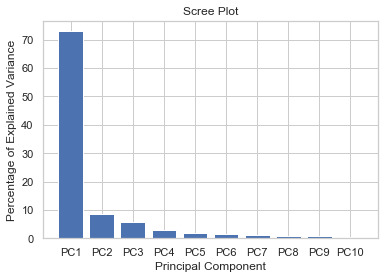

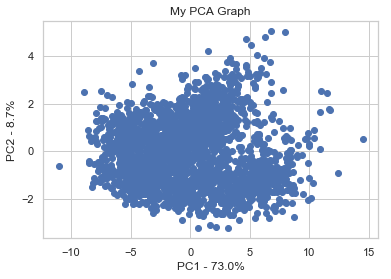

In [11]:
# The following code constructs the Scree plot
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.savefig('Scree_Plot_2SEX.png', dpi=300)
plt.show()

# the following code makes a fancy looking plot using PC
pca_df = pd.DataFrame(pc, columns=labels)

plt.scatter(pca_df.PC1, pca_df.PC2)
plt.title('My PCA Graph')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))

plt.savefig('PCA Scatter 2SEX.png', dpi=300)
plt.show()

# Model Selection
Since there are several linear relationships, I'll start with some linear models.

In [12]:
# Defining cross-validation parameters.
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

# Defining X and y
y = df_full['CHEST CIRCUMFERENCE']

# Creating my training data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

## Random Forest Regression

R² for the RF model: 
 0.988397627181115
Accuracy Score: 
 0.988397627181115

Mean (SD) Cross Validation Score: 0.93 (+/- 0.00)

Cross Validation Scores: 
 [0.92720155 0.93094342 0.92959292 0.92878831 0.93001245]
Feature ranking:
('WEIGHT', 0, 0.6503114690107384)
('STATURE', 8, 0.28772389323833214)
('ERECT SITTING HEIGHT', 10, 0.0074022007496643925)
('MAXIMUM HIP BREADTH (SEATED)', 15, 0.006650357360712111)
('BUTTOCK-KNEE LENGTH', 12, 0.005745002546436651)
('KNEE HEIGHT', 18, 0.004293621463583702)
('HEAD CIRCUMFERENCE', 21, 0.004059042012076487)
('HEAD BREADTH', 16, 0.003072756774593879)
('SHOULDER BREADTH', 2, 0.002820342381519046)
('SHOULDER-ELBOW LENGTH', 6, 0.002663214917501449)
('UPPER ARM CIRCUMFERENCE', 1, 0.0024882637637296673)
('ELBOW-HAND LENGTH', 17, 0.0024691906690804738)
('FOREARM CIRCUMFERENCE', 20, 0.0023372409527099534)
('HAND LENGTH', 19, 0.0023198809461705506)
('HAND BREADTH', 3, 0.0021453848976592032)
('WAIST CIRCUMFERENCE', 7, 0.0020470546704710554)
('HIP CIRCUMFERE

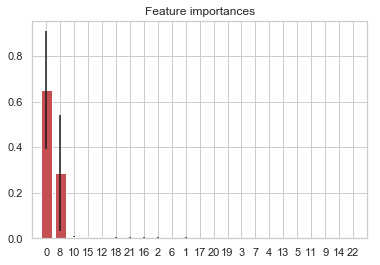

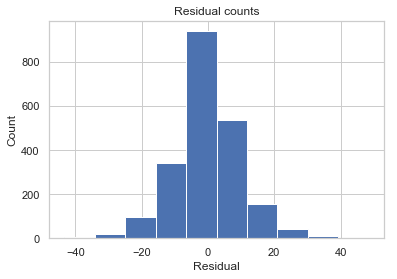

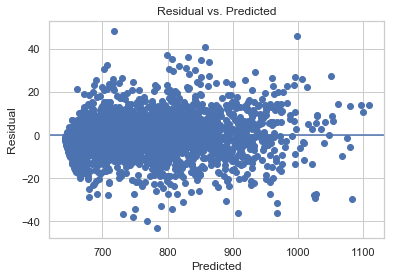

In [13]:
# Random forest regression

rfr = ensemble.RandomForestRegressor()
rfrfit = rfr.fit(X, y)

print('R² for the RF model: \n', rfrfit.score(X, y))
print('Accuracy Score: \n', rfrfit.score(X, y))
score = cross_val_score(rfrfit, X, y, cv=cv)
print("\nMean (SD) Cross Validation Score: %0.2f (+/- %0.2f)" %
      (score.mean(), score.std() * 2))
print('\nCross Validation Scores: \n', score)

importances = rfr.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print((X.columns[f], indices[f],
           importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# Extract predicted values.
predicted = rfrfit.predict(X).ravel()
actual = y

# Calculate the error, also called the residual.
residual = actual - predicted

# Plot Residual distribution
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.savefig('Residual Counts RF 2sex.png', dpi=300)
plt.show()

# Plot Residual vs. Predicted
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.savefig('Scedacity RF 2sex.png', dpi=300)
plt.show()

## Random Forest Regression With Tuned Hyperparameters

In [14]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [80, 90, 100, 110],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

In [15]:
rfr = ensemble.RandomForestRegressor()
rfrfit = rfr.fit(X, y)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rfrfit, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X, y)
grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 10.2min finished


{'bootstrap': True,
 'max_depth': 110,
 'min_samples_leaf': 4,
 'min_samples_split': 12,
 'n_estimators': 100}

R² for the RF model: 
 0.9760984522735346
Accuracy Score: 
 0.9760984522735346

Mean (SD) Cross Validation Score: 0.94 (+/- 0.01)

Cross Validation Scores: 
 [0.93561086 0.93124147 0.94259355 0.93415921 0.9389976 ]
Feature ranking:
('WEIGHT', 0, 0.5063081686222238)
('STATURE', 8, 0.4454520038211968)
('ERECT SITTING HEIGHT', 10, 0.00881807062328448)
('MAXIMUM HIP BREADTH (SEATED)', 12, 0.008015222644219588)
('BUTTOCK-KNEE LENGTH', 15, 0.005295957922527511)
('KNEE HEIGHT', 18, 0.002544115463796337)
('HEAD CIRCUMFERENCE', 21, 0.00242068234271707)
('HEAD BREADTH', 16, 0.0021988207570491068)
('SHOULDER BREADTH', 2, 0.0017928181045678906)
('SHOULDER-ELBOW LENGTH', 6, 0.0016914908752807898)
('UPPER ARM CIRCUMFERENCE', 17, 0.001578406822621316)
('ELBOW-HAND LENGTH', 7, 0.001535451064174556)
('FOREARM CIRCUMFERENCE', 4, 0.0014925185924447569)
('HAND LENGTH', 19, 0.0014842204102362266)
('HAND BREADTH', 5, 0.001387813349833635)
('WAIST CIRCUMFERENCE', 3, 0.001268494152261411)
('HIP CIRCUMFERENCE'

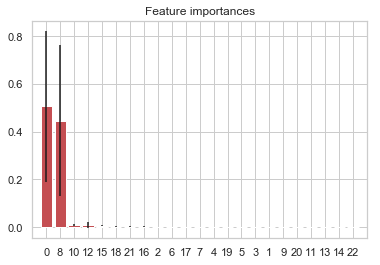

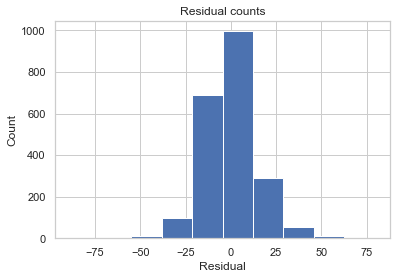

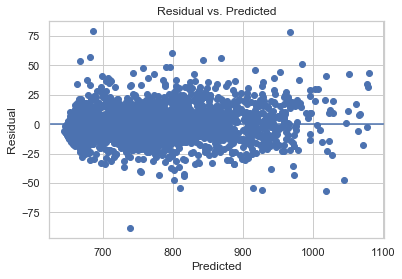

In [16]:
# Random forest regression

rfr = ensemble.RandomForestRegressor(bootstrap=True,
                                     max_depth=110,
                                     min_samples_leaf=4,
                                     min_samples_split=12,
                                     n_estimators=100)
rfrfit = rfr.fit(X, y)

print('R² for the RF model: \n', rfrfit.score(X, y))
print('Accuracy Score: \n', rfrfit.score(X, y))
score = cross_val_score(rfrfit, X, y, cv=cv)
print("\nMean (SD) Cross Validation Score: %0.2f (+/- %0.2f)" %
      (score.mean(), score.std() * 2))
print('\nCross Validation Scores: \n', score)

importances = rfr.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print((X.columns[f], indices[f],
           importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# Extract predicted values.
predicted = rfrfit.predict(X).ravel()
actual = y

# Calculate the error, also called the residual.
residual = actual - predicted

# Plot Residual distribution
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.savefig('Residual Counts RF T2sex.png', dpi=300)
plt.show()

# Plot Residual vs. Predicted
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.savefig('Scedacity TRF 2sex.png', dpi=300)
plt.show()

Reducing features does not improve model performance, however its does
make the model simpler.

R² for the mlp model: 
 0.9388534969867761
Accuracy Score: 
 0.9388534969867761

Mean (SD) Cross Validation Score: 0.93 (+/- 0.01)

Cross Validation Scores: 
 [0.93470226 0.92816759 0.93976077 0.93028473 0.93552777]


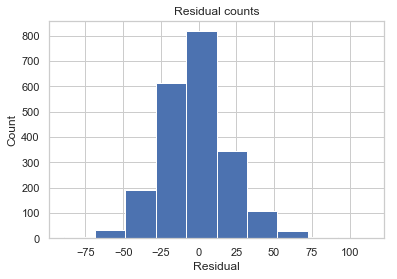

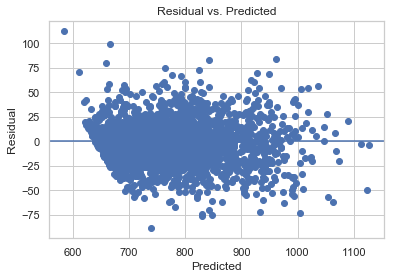

In [19]:
import sklearn.neural_network as NN
mlp = NN.MLPRegressor()
mlpfit = mlp.fit(X, y)

print('R² for the mlp model: \n', mlpfit.score(X, y))
print('Accuracy Score: \n', mlpfit.score(X, y))
score = cross_val_score(mlpfit, X, y, cv=cv)
print("\nMean (SD) Cross Validation Score: %0.2f (+/- %0.2f)" %
      (score.mean(), score.std() * 2))
print('\nCross Validation Scores: \n', score)

# Extract predicted values.
predicted = mlpfit.predict(X).ravel()
actual = y

# Calculate the error, also called the residual.
residual = actual - predicted

# Plot Residual distribution
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
#plt.savefig('Residual Counts RF T2sex.png', dpi=300)
plt.show()

# Plot Residual vs. Predicted
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
#plt.savefig('Scedacity TRF 2sex.png', dpi=300)
plt.show()

In [20]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search
param_grid2 = {
    'hidden_layer_sizes': [(100,), (200,)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam']
}

R² for the mlp model: 
 0.9388534969867761
Accuracy Score: 
 0.9388534969867761

Mean (SD) Cross Validation Score: 0.93 (+/- 0.01)

Cross Validation Scores: 
 [0.92867987 0.92979492 0.93955331 0.92588792 0.92677801]


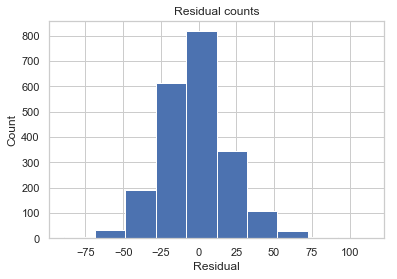

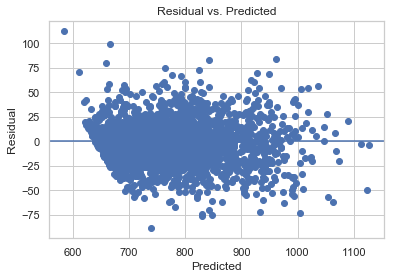

In [25]:
import sklearn.neural_network as NN
mlp = NN.MLPRegressor(hidden_layer_sizes=(500,200, ), activation='relu',
                      solver='adam', alpha=0.01)

print('R² for the mlp model: \n', mlpfit.score(X, y))
print('Accuracy Score: \n', mlpfit.score(X, y))
score = cross_val_score(mlpfit, X, y, cv=cv)
print("\nMean (SD) Cross Validation Score: %0.2f (+/- %0.2f)" %
      (score.mean(), score.std() * 2))
print('\nCross Validation Scores: \n', score)

# Extract predicted values.
predicted = mlpfit.predict(X).ravel()
actual = y

# Calculate the error, also called the residual.
residual = actual - predicted

# Plot Residual distribution
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
#plt.savefig('Residual Counts RF T2sex.png', dpi=300)
plt.show()

# Plot Residual vs. Predicted
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
#plt.savefig('Scedacity TRF 2sex.png', dpi=300)
plt.show()

Nothing changed by adjusting hyperparameters.